In [1]:
import pandas as pd
import yfinance
from datetime import date,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import plotly.express as px
import joblib
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

In [12]:
StartDate = (date.today()-timedelta(days=365*2-1)).strftime('%Y-%m-%d')
EndDate= (date.today()).strftime('%Y-%m-%d')
StartDate,EndDate

('2022-01-31', '2024-01-30')

In [13]:
ticker = "^NSEI"
df=yfinance.download(tickers=ticker,start=StartDate,end=EndDate,interval='1h')
print(df.shape)
df.head(15)

[*********************100%%**********************]  1 of 1 completed

(3445, 6)


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-01-31 09:15:00+05:30,17301.050781,17361.400391,17271.599609,17336.250000,17336.250000,0
2022-01-31 10:15:00+05:30,17337.150391,17359.000000,17264.349609,17339.449219,17339.449219,0
2022-01-31 11:15:00+05:30,17339.449219,17393.750000,17312.099609,17386.900391,17386.900391,0
2022-01-31 12:15:00+05:30,17386.349609,17406.449219,17349.750000,17391.099609,17391.099609,0
2022-01-31 13:15:00+05:30,17390.699219,17409.900391,17324.800781,17379.300781,17379.300781,0
2022-01-31 14:15:00+05:30,17380.449219,17407.250000,17333.949219,17339.099609,17339.099609,0
2022-01-31 15:15:00+05:30,17339.250000,17354.199219,17313.699219,17338.300781,17338.300781,0
2022-02-01 09:15:00+05:30,17529.449219,17583.949219,17469.150391,17578.099609,17578.099609,0
2022-02-01 10:15:00+05:30,17578.099609,17596.099609,17536.849609,17566.849609,17566.849609,0


<Axes: xlabel='Datetime'>

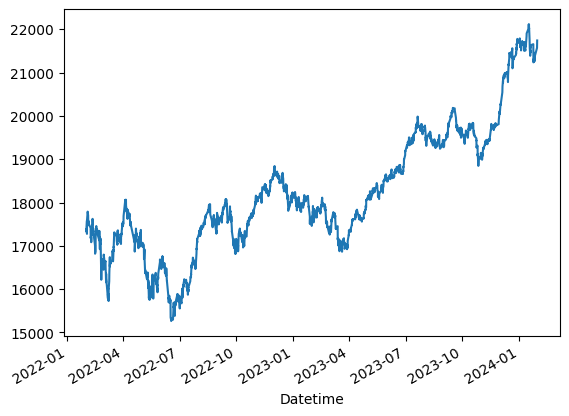

In [14]:
df['Close'].plot()

In [15]:
plt.figure(figsize=(15,7))
line=px.line(data_frame=df,x=df.index,y=df.columns,title="NIFTY-50 Stock Prices")
line.show()

<Figure size 1500x700 with 0 Axes>

In [16]:
y = df[['Open','High','Low','Close','Adj Close']]
for i in range(len(y.columns)):
    adfTest = adfuller(y[y.columns[i]],autolag='AIC')
    if adfTest[1]<0.05:
        print(f'{adfTest[1]} is stationarity {y.columns[i]}')
    else:
        print(f'{adfTest[1]} is not stationarity {y.columns[i]}')

0.950009725238805 is not stationarity Open
0.9595647068237185 is not stationarity High
0.9575102510668365 is not stationarity Low
0.9605219068311781 is not stationarity Close
0.9605219068311781 is not stationarity Adj Close


In [17]:
train_size = int(0.8 * len(y))
train, test = y[:train_size], y[train_size:]
y.dropna(inplace=True)
exogtrain = train['Open']
exogtrain2=train['High']
exogtrain3=train['Low']
exogtest = test['Open']
exogtest2=test['High']
exogtest3=test['Low']
exogtrain.shape,exogtest.shape,train.shape,test.shape

/tmp/ipykernel_6350/3190282135.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



((2756,), (689,), (2756, 5), (689, 5))

In [18]:
exogdftrain = pd.concat([exogtrain, exogtrain2, exogtrain3], axis=1)
exogdftest = pd.concat([exogtest, exogtest2, exogtest3], axis=1)
train.index = pd.date_range(start=train.index[0], periods=len(train), freq='H')
exogdftrain.index = train.index
var_model = VAR(endog=train,dates=train.index,exog=exogdftrain)
var_fit = var_model.fit(trend='c'
                        ,verbose=True,)
predictions3=var_fit.forecast(y=train.values, steps=len(test),exog_future=exogdftest.values)
predictions3

array([[19392.09960938, 19439.94921875, 19384.40039063, 19428.02780905,
        19428.02780905],
       [19436.05078125, 19458.5       , 19425.19921875, 19448.75067102,
        19448.75067102],
       [19435.15039063, 19441.34960938, 19421.90039063, 19431.05685527,
        19431.05685527],
       ...,
       [21705.05078125, 21745.05078125, 21672.84960938, 21716.7653368 ,
        21716.7653368 ],
       [21721.25      , 21752.19921875, 21687.15039063, 21723.95637809,
        21723.95637809],
       [21741.25      , 21762.80078125, 21738.75      , 21762.45324227,
        21762.45324227]])

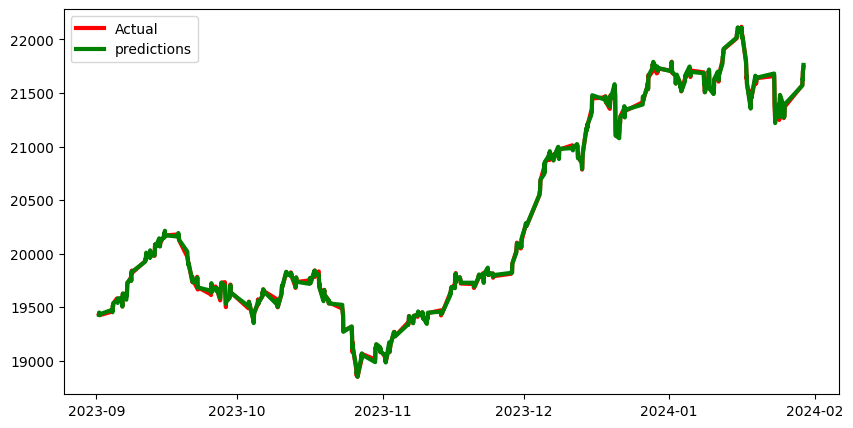

In [19]:
var_dataset = pd.DataFrame(data=predictions3,index=test.index,columns=train.columns)
plt.figure(figsize=(10,5))
plt.plot(test['Close'],label="Actual",color="red",linestyle="-",linewidth="3")
plt.plot(var_dataset['Close'],label="predictions",color="green",linestyle="-",linewidth="3")
plt.legend()

In [20]:
model=joblib.dump(var_fit,'Var.joblib')

In [11]:
mean_squared_error(test,predictions3)

2.7554739222002826